In [67]:
#importing needed libraries
import numpy as np
from scipy.spatial import distance
import cvxopt
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [68]:
#svm implementation
class SVM:
    def __init__(self, kernel='rbf', C=1, k=2):
        """
        Initialize the SVM classifier with specified kernel and hyperparameters.

        Parameters:
        - kernel (str): The type of kernel function to be used. Default is 'rbf'.
        - C (float): The regularization parameter. Default is 1.
        - k (int): The number of classes for multiclass classification. Default is 2.
        """
        self.kernel_str = kernel
        self.kernel = self._get_kernel_function(kernel)
        self.C = C
        self.k = k
        self.X, self.y = None, None
        self.αs = None
        self.multiclass = False
        self.clfs = []

    def _get_kernel_function(self, kernel):
        """
        Get the kernel function based on the specified kernel type.

        Parameters:
        - kernel (str): The type of kernel function.

        Returns:
        - kernel_func (function): The kernel function.
        """
        linear = lambda x, xࠤ, c=0: x @ xࠤ.T
        polynomial = lambda x, xࠤ, Q=5: (1 + x @ xࠤ.T) ** Q
        rbf = lambda x, xࠤ, γ=10: np.exp(-γ * distance.cdist(x, xࠤ, 'sqeuclidean'))
        kernel_funs = {'linear': linear, 'polynomial': polynomial, 'rbf': rbf}
        return kernel_funs[kernel]

    def fit(self, X, y, eval_train=False):
        """
        Train the SVM classifier for binary or multiclass classification.

        Parameters:
        - X (array-like): The input features.
        - y (array-like): The target labels.
        - eval_train (bool): Whether to evaluate the training accuracy. Default is False.
        """
        if len(np.unique(y)) > 2:
            self.multiclass = True
            return self.multi_fit(X, y, eval_train)

        y = self._relabel(y)
        self.y = y.reshape(-1, 1).astype(np.double)
        self.X = X
        N = X.shape[0]
        self.K = self.kernel(X, X, self.k)

        # Prepare optimization problem for binary classification
        P = cvxopt.matrix(self.y @ self.y.T * self.K)
        q = cvxopt.matrix(-np.ones((N, 1)))
        A = cvxopt.matrix(self.y.T)
        b = cvxopt.matrix(np.zeros(1))
        G = cvxopt.matrix(np.vstack((-np.identity(N), np.identity(N))))
        h = cvxopt.matrix(np.vstack((np.zeros((N, 1)), np.ones((N, 1)) * self.C)))

        # Solve optimization problem using quadratic programming
        cvxopt.solvers.options['show_progress'] = False
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.αs = np.array(sol["x"])

        # Identify support vectors and margin support vector
        self.is_sv = ((self.αs > 1e-3) & (self.αs <= self.C)).squeeze()
        self.margin_sv = np.argmax((1e-3 < self.αs) & (self.αs < self.C - 1e-3))

        if eval_train:
            print(f"Finished training with accuracy {self.evaluate(X, y)}")

    def multi_fit(self, X, y, eval_train=False):
        """
        Train the SVM classifier for multiclass classification using the one-vs-all approach.

        Parameters:
        - X (array-like): The input features.
        - y (array-like): The target labels.
        - eval_train (bool): Whether to evaluate the training accuracy. Default is False.
        """
        self.k = len(np.unique(y))
        for i in range(self.k):
            Xs, Ys = X, copy.copy(y)
            Ys[Ys != i], Ys[Ys == i] = -1, +1
            clf = SVM(kernel=self.kernel_str, C=self.C, k=self.k)
            clf.fit(Xs, Ys)
            self.clfs.append(clf)
        if eval_train:
            print(f"Finished training with accuracy {self.evaluate(X, y)}")

    def _relabel(self, y):
        """
        Relabel binary classification targets to -1 and 1.

        Parameters:
        - y (array-like): The target labels.

        Returns:
        - relabeled_y (array-like): The relabeled target labels.
        """
        if set(np.unique(y)) == {0, 1}:
            y[y == 0] = -1
        return y

    def predict(self, X_t):
        """
        Make predictions for binary classification.

        Parameters:
        - X_t (array-like): The input features for prediction.

        Returns:
        - predictions (array-like): The predicted labels.
        - scores (array-like): The decision scores.
        """
        if self.multiclass:
            return self.multi_predict(X_t)
        xₛ, yₛ = self.X[self.margin_sv, np.newaxis], self.y[self.margin_sv]
        αs, y, X = self.αs[self.is_sv], self.y[self.is_sv], self.X[self.is_sv]

        # Calculate decision boundary and make predictions
        b = yₛ - np.sum(αs * y * self.kernel(X, xₛ, self.k), axis=0)
        pred = np.sum(αs * y * self.kernel(X, X_t, self.k), axis=0) + b
        return np.sign(pred).astype(int), pred

    def multi_predict(self, X):
        """
        Make predictions for multiclass classification.

        Parameters:
        - X (array-like): The input features for prediction.

        Returns:
        - predictions (array-like): The predicted labels.
        """
        preds = np.zeros((X.shape[0], self.k))
        for i, clf in enumerate(self.clfs):
            _, preds[:, i] = clf.predict(X)

        # Get the class with the highest prediction score
        return np.argmax(preds, axis=1)

    def evaluate(self, X, y):
        """
        Evaluate the accuracy of the model on the given data.

        Parameters:
        - X (array-like): The input features.
        - y (array-like): The target labels.

        Returns:
        - accuracy (float): The accuracy of the model.
        """
        outputs = self.predict(X)
        accuracy = np.sum(outputs == y) / len(y)
        return round(accuracy, 2)


#### Loading the datasets into dataframes to start the analysis

In [69]:
# Load all the datasets
Aggregation_dataset = pd.read_csv('Aggregation.txt', header=None, delimiter='\t', skiprows=7)
Aggregation_dataset.columns = ['feature1', 'feature2', 'target']

Compound_dataset = pd.read_csv('Compound.txt', header=None, delimiter='\t', skiprows=7)
Compound_dataset.columns = ['feature1', 'feature2', 'target']

Flame_dataset = pd.read_csv('Flame.txt', header=None, delimiter='\t', skiprows=7)
Flame_dataset.columns = ['feature1', 'feature2', 'target']

Jain_dataset = pd.read_csv('Jain.txt', header=None, delimiter='\t', skiprows=7)
Jain_dataset.columns = ['feature1', 'feature2', 'target']

Pathbased_dataset = pd.read_csv('Pathbased.txt', header=None, delimiter='\t', skiprows=7)
Pathbased_dataset.columns = ['feature1', 'feature2', 'target']

Spiral_dataset = pd.read_csv('Spiral.txt', header=None, delimiter='\t', skiprows=7)
Spiral_dataset.columns = ['feature1', 'feature2', 'target']



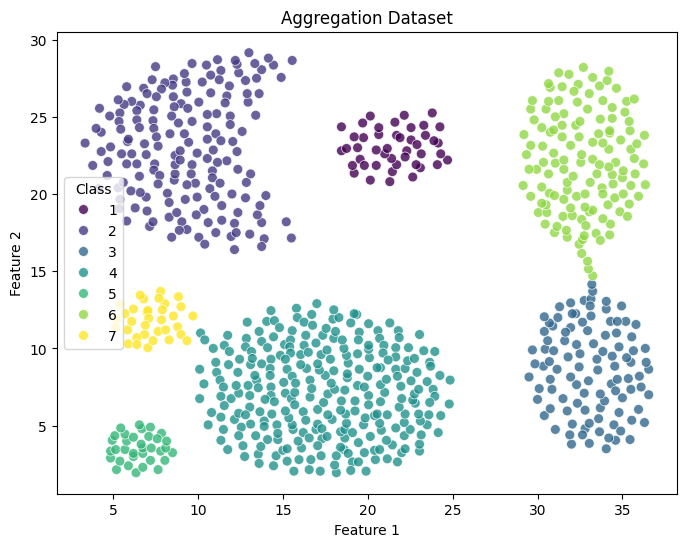

,feature1,feature2,target
count,788.000000,788.000000,788.000000
mean,19.566815,14.171764,3.770305
std,9.922042,8.089683,1.596305
min,3.350000,1.950000,1.000000
25%,11.150000,7.037500,2.000000
50%,18.225000,11.725000,4.000000
75%,30.700000,21.962500,5.000000
max,36.550000,29.150000,7.000000


In [70]:
#explore the Aggregation dataset
# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=Aggregation_dataset, x='feature1', y='feature2', hue='target', palette='viridis', s=50, alpha=0.8)
plt.title("Aggregation Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='Class')
plt.show()

Aggregation_dataset.describe()



1. Aggregation Dataset:
   - Distribution: The Aggregation dataset consists of seven distinct classes, each representing a different category for the samples. The scatter plot shows that the data points are clustered together in different regions, forming distinct groups.
   - Separability: The classes are well-separated, with clear boundaries between them. This indicates that the data points in each class are relatively close to each other and far from the data points in other classes.
   - The dataset contains a total of 787 samples.



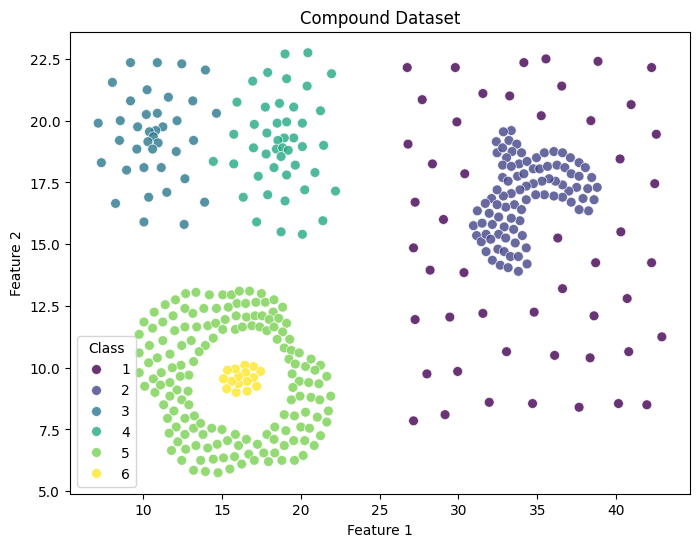

,feature1,feature2,target
count,399.000000,399.000000,399.000000
mean,22.215038,13.970677,3.543860
std,9.736752,4.743516,1.581125
min,7.150000,5.750000,1.000000
25%,14.100000,9.775000,2.000000
50%,18.950000,14.150000,4.000000
75%,32.725000,18.125000,5.000000
max,42.900000,22.750000,6.000000


In [71]:

# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=Compound_dataset, x='feature1', y='feature2', hue='target', palette='viridis', s=50, alpha=0.8)
plt.title("Compound Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='Class')
plt.show()

Compound_dataset.describe()


2. Compound Dataset:
   - Distribution: The Compound dataset consists of 6 classes. The scatter plot shows that the data points are distributed in a more complex pattern compared to the Aggregation dataset. There are overlapping regions between some classes.
   - Separability: The classes in the Compound dataset are less separable compared to the Aggregation dataset. There are regions where the data points from different classes overlap, making it more challenging to separate them accurately.
   - The dataset consists of a total of 398 samples.




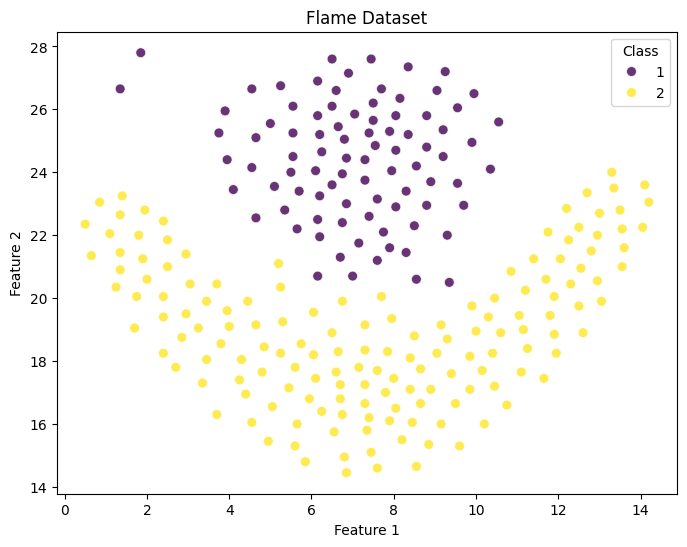

,feature1,feature2,target
count,240.000000,240.000000,240.000000
mean,7.323750,20.928542,1.637500
std,3.202509,3.383390,0.481727
min,0.500000,14.450000,1.000000
25%,5.250000,18.237500,1.000000
50%,7.300000,20.775000,2.000000
75%,9.312500,23.562500,2.000000
max,14.200000,27.800000,2.000000


In [72]:

# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=Flame_dataset, x='feature1', y='feature2', hue='target', palette='viridis', s=50, alpha=0.8)
plt.title("Flame Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='Class')
plt.show()

Flame_dataset.describe()


3. Flame Dataset:
   - Distribution: The Flame dataset contains 2 classes. The scatter plot shows that the data points are distributed in a flame-like shape, with some overlapping regions between classes.
   - Separability: The classes in the Flame dataset are relatively separable, but there are overlapping regions between some classes. It may require more complex decision boundaries to accurately separate the data points.
   - the dataset contains a total of 239 samples.


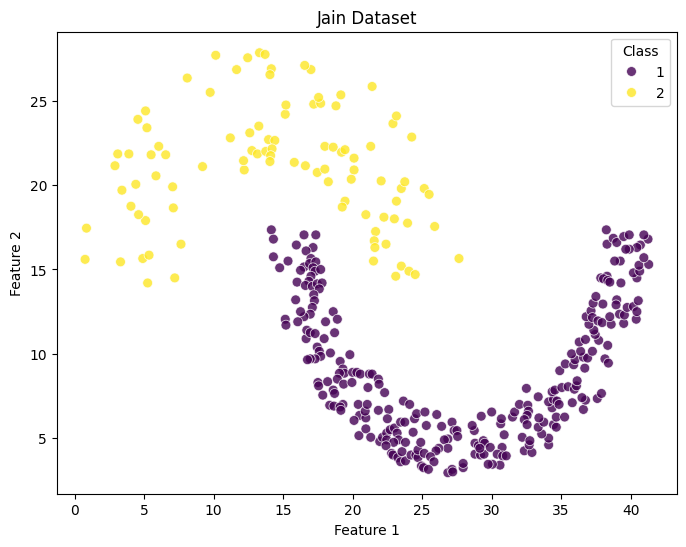

,feature1,feature2,target
count,373.000000,373.000000,373.000000
mean,24.330697,12.145979,1.260054
std,9.853372,6.605375,0.439253
min,0.750000,2.950000,1.000000
25%,17.350000,6.300000,1.000000
50%,23.150000,11.250000,1.000000
75%,33.350000,16.500000,2.000000
max,41.300000,27.850000,2.000000


In [73]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=Jain_dataset, x='feature1', y='feature2', hue='target', palette='viridis', s=50, alpha=0.8)
plt.title("Jain Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='Class')
plt.show()

Jain_dataset.describe()


4. Jain Dataset:
   - Distribution: The Jain dataset consists of 2 classes. The scatter plot shows that the data points are distributed in a complex pattern, with overlapping regions between classes.
   - Separability: The classes in the Jain dataset are less separable compared to the Aggregation dataset. There are overlapping regions between classes, making it challenging to separate the data points accurately.
   - The dataset contains a total of 372 samples.



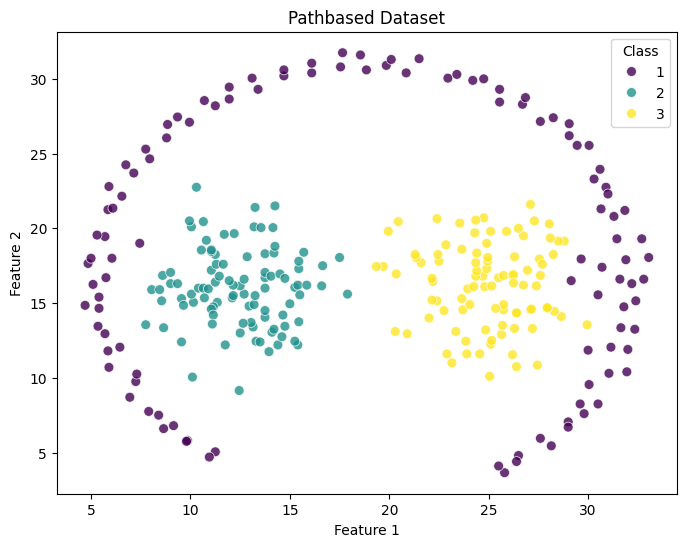

,feature1,feature2,target
count,300.000000,300.000000,300.000000
mean,18.846500,17.188500,1.943333
std,8.253238,5.855957,0.822015
min,4.700000,3.650000,1.000000
25%,11.287500,13.687500,1.000000
50%,19.100000,16.550000,2.000000
75%,26.250000,19.562500,3.000000
max,33.050000,31.750000,3.000000


In [74]:

# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=Pathbased_dataset, x='feature1', y='feature2', hue='target', palette='viridis', s=50, alpha=0.8)
plt.title("Pathbased Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='Class')
plt.show()

Pathbased_dataset.describe()

5. Pathbased Dataset:
   - Distribution: The Pathbased dataset contains 3 classes. The scatter plot shows that the data points are distributed in a path-like shape, with some overlapping regions between classes.
   - Separability: The classes in the Pathbased dataset are relatively separable, but there are overlapping regions between some classes. It may require more complex decision boundaries to accurately separate the data points (loke the flame data_set).
   - The dataset contains a total of 299 samples.



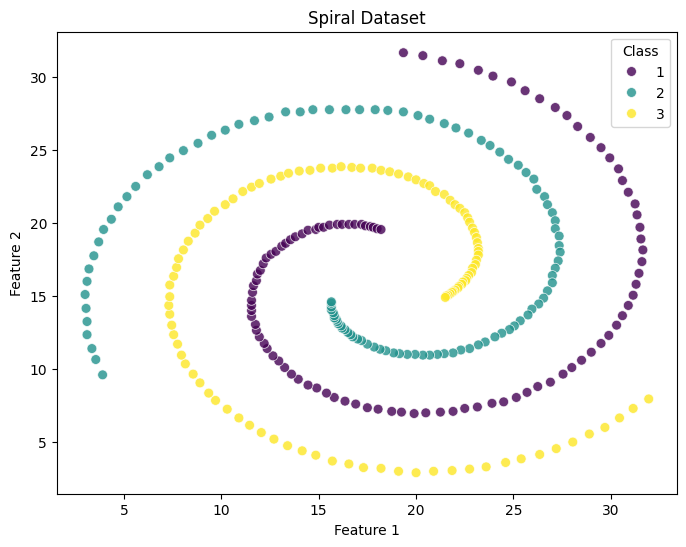

,feature1,feature2,target
count,312.000000,312.000000,312.000000
mean,18.408173,16.344712,2.016026
std,7.299923,6.867232,0.815682
min,3.000000,2.900000,1.000000
25%,12.912500,11.337500,1.000000
50%,18.325000,16.050000,2.000000
75%,23.400000,21.362500,3.000000
max,31.950000,31.650000,3.000000


In [75]:

# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=Spiral_dataset, x='feature1', y='feature2', hue='target', palette='viridis', s=50, alpha=0.8)
plt.title("Spiral Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='Class')
plt.show()

Spiral_dataset.describe()


6. Spiral Dataset:
   - Distribution: The Spiral dataset consists of 3 classes. The scatter plot shows that the data points are distributed in a spiral pattern, with overlapping regions between classes.
   - Separability: The classes in the Spiral dataset are less separable compared to the Aggregation dataset. There are overlapping regions between classes, making it challenging to separate the data points accurately.(like flame and pathbased)
   - The dataset contains a total of 311 samples.



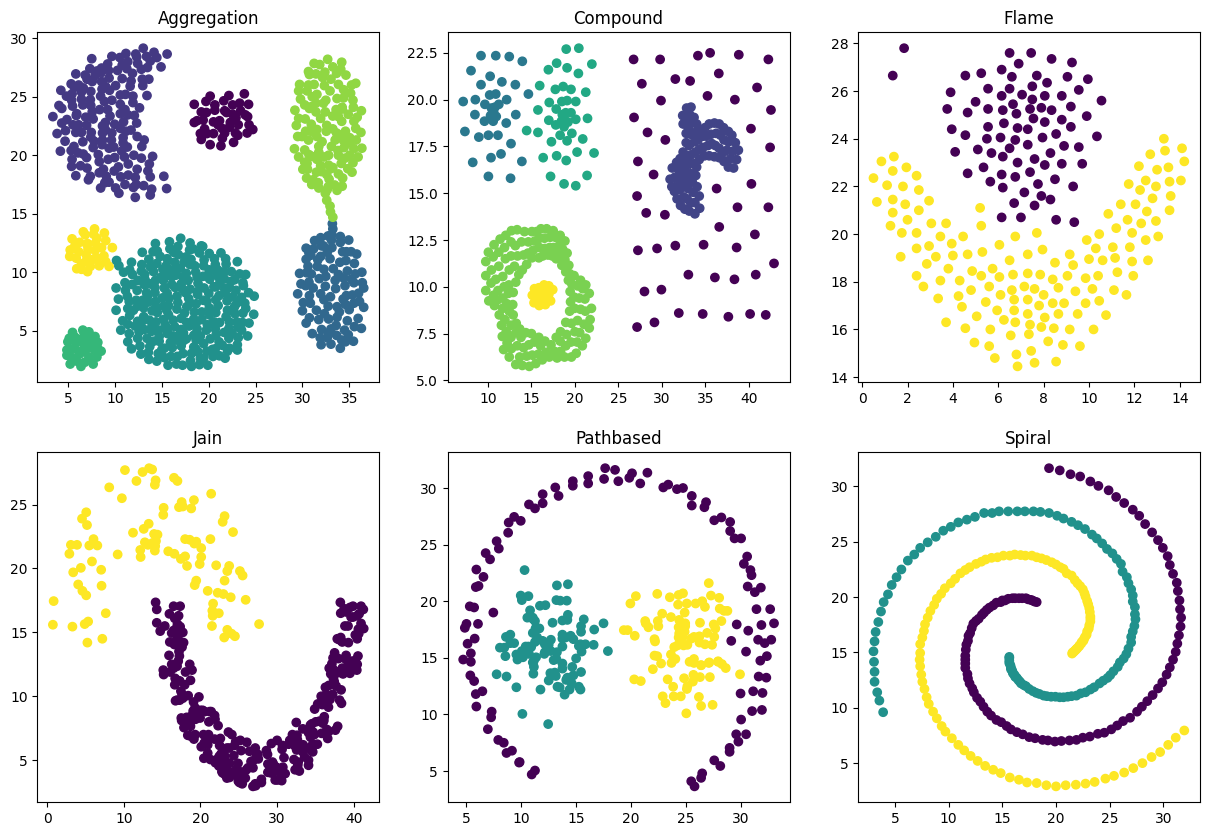

In [76]:
# Plot the datasets side by side
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.scatter(Aggregation_dataset['feature1'], Aggregation_dataset['feature2'], c=Aggregation_dataset['target'])
plt.title("Aggregation")
plt.subplot(2, 3, 2)
plt.scatter(Compound_dataset['feature1'], Compound_dataset['feature2'], c=Compound_dataset['target'])
plt.title("Compound")
plt.subplot(2, 3, 3)
plt.scatter(Flame_dataset['feature1'], Flame_dataset['feature2'], c=Flame_dataset['target'])
plt.title("Flame")
plt.subplot(2, 3, 4)
plt.scatter(Jain_dataset['feature1'], Jain_dataset['feature2'], c=Jain_dataset['target'])
plt.title("Jain")
plt.subplot(2, 3, 5)
plt.scatter(Pathbased_dataset['feature1'], Pathbased_dataset['feature2'], c=Pathbased_dataset['target'])
plt.title("Pathbased")
plt.subplot(2, 3, 6)
plt.scatter(Spiral_dataset['feature1'], Spiral_dataset['feature2'], c=Spiral_dataset['target'])
plt.title("Spiral")
plt.show()

Overall, the distribution and separability of the data points vary across the datasets. Some datasets have well-separated classes with clear boundaries, while others have overlapping regions between classes, making it more challenging to separate the data points accurately.

In [77]:
# divide the datasets into features and target
# Aggregation dataset
X_agg = Aggregation_dataset.iloc[:, :2]  
y_agg = Aggregation_dataset.iloc[:, 2]

# Compound dataset
X_comp = Compound_dataset.iloc[:, :2]
y_comp = Compound_dataset.iloc[:, 2]

# Flame dataset
X_flame = Flame_dataset.iloc[:, :2]
y_flame = Flame_dataset.iloc[:, 2]

# Jain dataset
X_jain = Jain_dataset.iloc[:, :2]
y_jain = Jain_dataset.iloc[:, 2]

# Pathbased dataset
X_path = Pathbased_dataset.iloc[:, :2]
y_path = Pathbased_dataset.iloc[:, 2]

# Spiral dataset
X_spiral = Spiral_dataset.iloc[:, :2]
y_spiral = Spiral_dataset.iloc[:, 2]


In [78]:
# Split each dataset into training and testing sets
X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(X_agg, y_agg, test_size=0.2, random_state=42)

X_train_comp, X_test_comp, y_train_comp, y_test_comp = train_test_split(X_comp, y_comp, test_size=0.2, random_state=42)

X_train_flame, X_test_flame, y_train_flame, y_test_flame = train_test_split(X_flame, y_flame, test_size=0.2, random_state=42)

X_train_jain, X_test_jain, y_train_jain, y_test_jain = train_test_split(X_jain, y_jain, test_size=0.2, random_state=42)

X_train_path, X_test_path, y_train_path, y_test_path = train_test_split(X_path, y_path, test_size=0.2, random_state=42)

X_train_spiral, X_test_spiral, y_train_spiral, y_test_spiral = train_test_split(X_spiral, y_spiral, test_size=0.2, random_state=42)

In [79]:
# Define a function to normalize a dataset
def normalize_dataset(X):
    # Normalize the features using StandardScaler
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    return X_normalized

In [80]:
# Normalize each dataset
X_train_agg_normalized = normalize_dataset(X_train_agg)
X_test_agg_normalized = normalize_dataset(X_test_agg)

X_train_comp_normalized = normalize_dataset(X_train_comp)
X_test_comp_normalized = normalize_dataset(X_test_comp)

X_train_flame_normalized = normalize_dataset(X_train_flame)
X_test_flame_normalized = normalize_dataset(X_test_flame)

X_train_jain_normalized = normalize_dataset(X_train_jain)
X_test_jain_normalized = normalize_dataset(X_test_jain)

X_train_path_normalized = normalize_dataset(X_train_path)
X_test_path_normalized = normalize_dataset(X_test_path)

X_train_spiral_normalized = normalize_dataset(X_train_spiral)
X_test_spiral_normalized = normalize_dataset(X_test_spiral)

In [81]:
# Define a function to train an SVM classifier
def train_svm_classifier(X_train, y_train, X_test, y_test, kernel_type='linear', C_value=1.0):
    # Create SVM classifier with specified kernel and C value
    svm_classifier = SVM(kernel=kernel_type, C=C_value)
    

    # Train the SVM classifier
    svm_classifier.fit(X_train, y_train, eval_train=True)
    # Make predictions on the test set
    y_pred = svm_classifier.predict(X_test)

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Kernel: {kernel_type}, C: {C_value}, Accuracy: {accuracy:.2f}")
    # Return accuracy and the trained classifier
    return accuracy, svm_classifier

In [82]:
# Train SVM classifiers for each dataset and configuration
kernels = ['linear', 'polynomial', 'rbf']
C_values = [0.01, 1.0, 1000.0]  # You can adjust these values based on your requirements



Training SVM Classifier with linear kernel and C=0.01:


Finished training with accuracy 0.72
Kernel: linear, C: 0.01, Accuracy: 0.75

Training SVM Classifier with linear kernel and C=1.0:
Finished training with accuracy 0.87
Kernel: linear, C: 1.0, Accuracy: 0.89

Training SVM Classifier with linear kernel and C=1000.0:
Finished training with accuracy 0.91
Kernel: linear, C: 1000.0, Accuracy: 0.92

Training SVM Classifier with polynomial kernel and C=0.01:
Finished training with accuracy 0.87
Kernel: polynomial, C: 0.01, Accuracy: 0.92

Training SVM Classifier with polynomial kernel and C=1.0:
Finished training with accuracy 0.91
Kernel: polynomial, C: 1.0, Accuracy: 0.94

Training SVM Classifier with polynomial kernel and C=1000.0:
Finished training with accuracy 0.91
Kernel: polynomial, C: 1000.0, Accuracy: 0.94

Training SVM Classifier with rbf kernel and C=0.01:
Finished training with accuracy 0.95
Kernel: rbf, C: 0.01, Accuracy: 0.97

Training SVM Classifier with rbf kernel and C=1.0:
Finished training with accuracy 0.95
Kernel: rbf, C

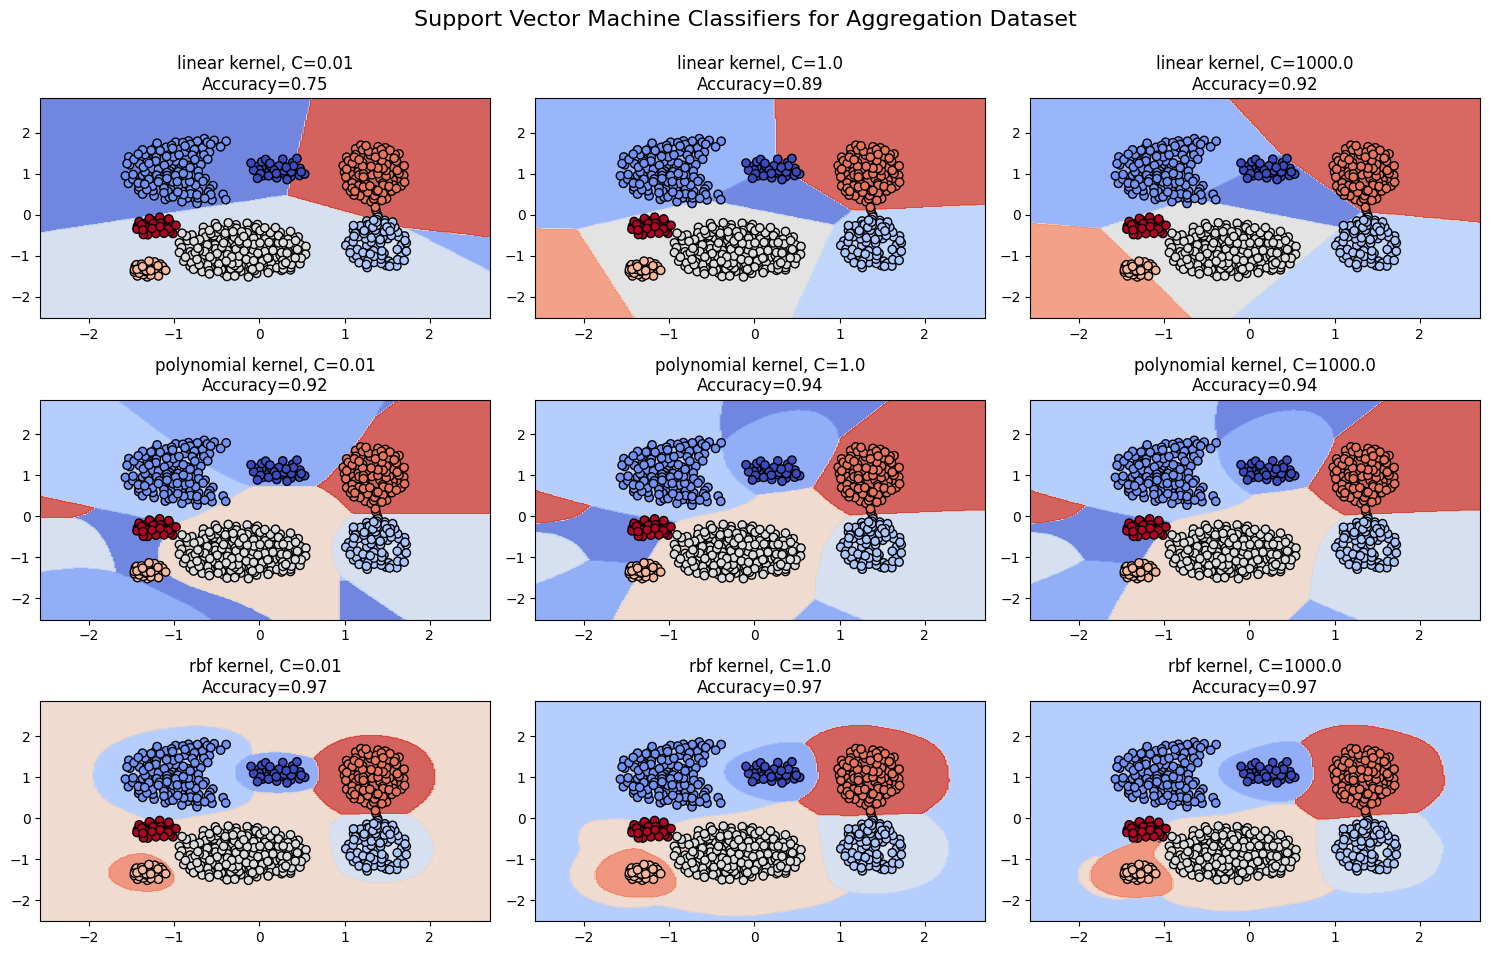

In [83]:
#visualize the decision boundary for the Aggregation dataset and configuration
# Initialize a subplot
fig, axs = plt.subplots(len(kernels), len(C_values), figsize=(15, 10))

# Iterate over kernels and C values
for i, kernel in enumerate(kernels):
    for j, C_value in enumerate(C_values):
        print(f"\nTraining SVM Classifier with {kernel} kernel and C={C_value}:")

        # Train SVM classifier
        accuracy, classifier = train_svm_classifier(X_train_agg_normalized, y_train_agg.values, X_test_agg_normalized, y_test_agg.values, kernel_type=kernel, C_value=C_value)

        # Make predictions on a meshgrid to visualize decision boundary
        h = .02  # Step size in the mesh
        x_min, x_max = X_train_agg_normalized[:, 0].min() - 1, X_train_agg_normalized[:, 0].max() + 1
        y_min, y_max = X_train_agg_normalized[:, 1].min() - 1, X_train_agg_normalized[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Plot the decision boundary
        axs[i, j].contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

        # Plot the training points
        axs[i, j].scatter(X_train_agg_normalized[:, 0], X_train_agg_normalized[:, 1], c=y_train_agg.values, cmap=plt.cm.coolwarm, edgecolors='k')
        axs[i, j].set_title(f"{kernel} kernel, C={C_value}\nAccuracy={accuracy:.2f}")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Support Vector Machine Classifiers for Aggregation Dataset', fontsize=16)
plt.show()


1. Linear Kernel:
- C=0.01:

Kernel: linear, C: 0.01, Accuracy: 0.75
Interpretation: The linear kernel with a low regularization strength (C=0.01) results in an accuracy of 0.72 during training, and the final accuracy on the dataset is 0.75. The low accuracy suggests that the model might be underfitting due to its simplicity.
- C=1.0:


Kernel: linear, C: 1.0, Accuracy: 0.89
Interpretation: The linear kernel with a moderate regularization strength (C=1.0) improves accuracy during training to 0.87, and the final accuracy on the dataset is 0.89. This suggests that increasing the penalty for misclassification has a positive effect, leading to a better fit.
- C=1000.0:


Kernel: linear, C: 1000.0, Accuracy: 0.92
Interpretation: Further increasing the regularization strength to C=1000.0 results in a training accuracy of 0.91 and a final accuracy of 0.92. The model's performance continues to improve, but the gain is less substantial compared to the transition from C=0.01 to C=1.0.

2. Polynomial Kernel:
- C=0.01:
Kernel: polynomial, C: 0.01, Accuracy: 0.92
Interpretation: The polynomial kernel with a low regularization strength (C=0.01) achieves a training accuracy of 0.87 and a final accuracy of 0.92. This indicates that the polynomial kernel, even with a low penalty for misclassification, captures the dataset's complexity well.
- C=1.0:


Kernel: polynomial, C: 1.0, Accuracy: 0.94
Interpretation: Increasing the regularization strength to C=1.0 improves training accuracy to 0.91, and the final accuracy on the dataset is 0.94. This suggests that the polynomial kernel benefits from a higher penalty for misclassification.
- C=1000.0:

Kernel: polynomial, C: 1000.0, Accuracy: 0.94
Interpretation: Further increasing C to 1000.0 results in similar training and final accuracies, indicating that the model does not gain much by increasing the regularization strength beyond C=1.0.

3. Radial Basis Function (RBF) Kernel:
- C=0.01:

Kernel: rbf, C: 0.01, Accuracy: 0.97
Interpretation: The RBF kernel with a very low regularization strength (C=0.01) achieves high training accuracy (0.95) and a final accuracy of 0.97. This suggests that the RBF kernel, even with low regularization, effectively captures the dataset's patterns.
- C=1.0:


Kernel: rbf, C: 1.0, Accuracy: 0.97
Interpretation: The RBF kernel maintains high accuracy (0.95 during training, 0.97 final accuracy) with a moderate regularization strength (C=1.0), indicating stability and robustness.
- C=1000.0:

Kernel: rbf, C: 1000.0, Accuracy: 0.97
Interpretation: Further increasing the regularization strength to C=1000.0 does not significantly impact accuracy, suggesting that the RBF kernel is already performing well with C=1.0.

The RBF kernel consistently performs well across different regularization strengths, indicating its robustness for the aggregation dataset.
The linear kernel benefits from increased regularization (C=1.0 to C=1000.0) but with diminishing returns.
The polynomial kernel performs well, especially with a low regularization strength (C=0.01 to C=1.0), but does not gain much with further regularization (C=1000.0).
In summary, for the aggregation dataset, the RBF kernel with a moderate regularization strength (C=1.0) stands out as the most effective choice, providing high accuracy during both training and on the dataset.



Training SVM Classifier with linear kernel and C=0.01:
Finished training with accuracy 0.65
Kernel: linear, C: 0.01, Accuracy: 0.59

Training SVM Classifier with linear kernel and C=1.0:
Finished training with accuracy 0.73
Kernel: linear, C: 1.0, Accuracy: 0.72

Training SVM Classifier with linear kernel and C=1000.0:
Finished training with accuracy 0.75
Kernel: linear, C: 1000.0, Accuracy: 0.75

Training SVM Classifier with polynomial kernel and C=0.01:
Finished training with accuracy 0.92
Kernel: polynomial, C: 0.01, Accuracy: 0.85

Training SVM Classifier with polynomial kernel and C=1.0:
Finished training with accuracy 0.94
Kernel: polynomial, C: 1.0, Accuracy: 0.78

Training SVM Classifier with polynomial kernel and C=1000.0:
Finished training with accuracy 0.95
Kernel: polynomial, C: 1000.0, Accuracy: 0.78

Training SVM Classifier with rbf kernel and C=0.01:
Finished training with accuracy 0.84
Kernel: rbf, C: 0.01, Accuracy: 0.74

Training SVM Classifier with rbf kernel and C=

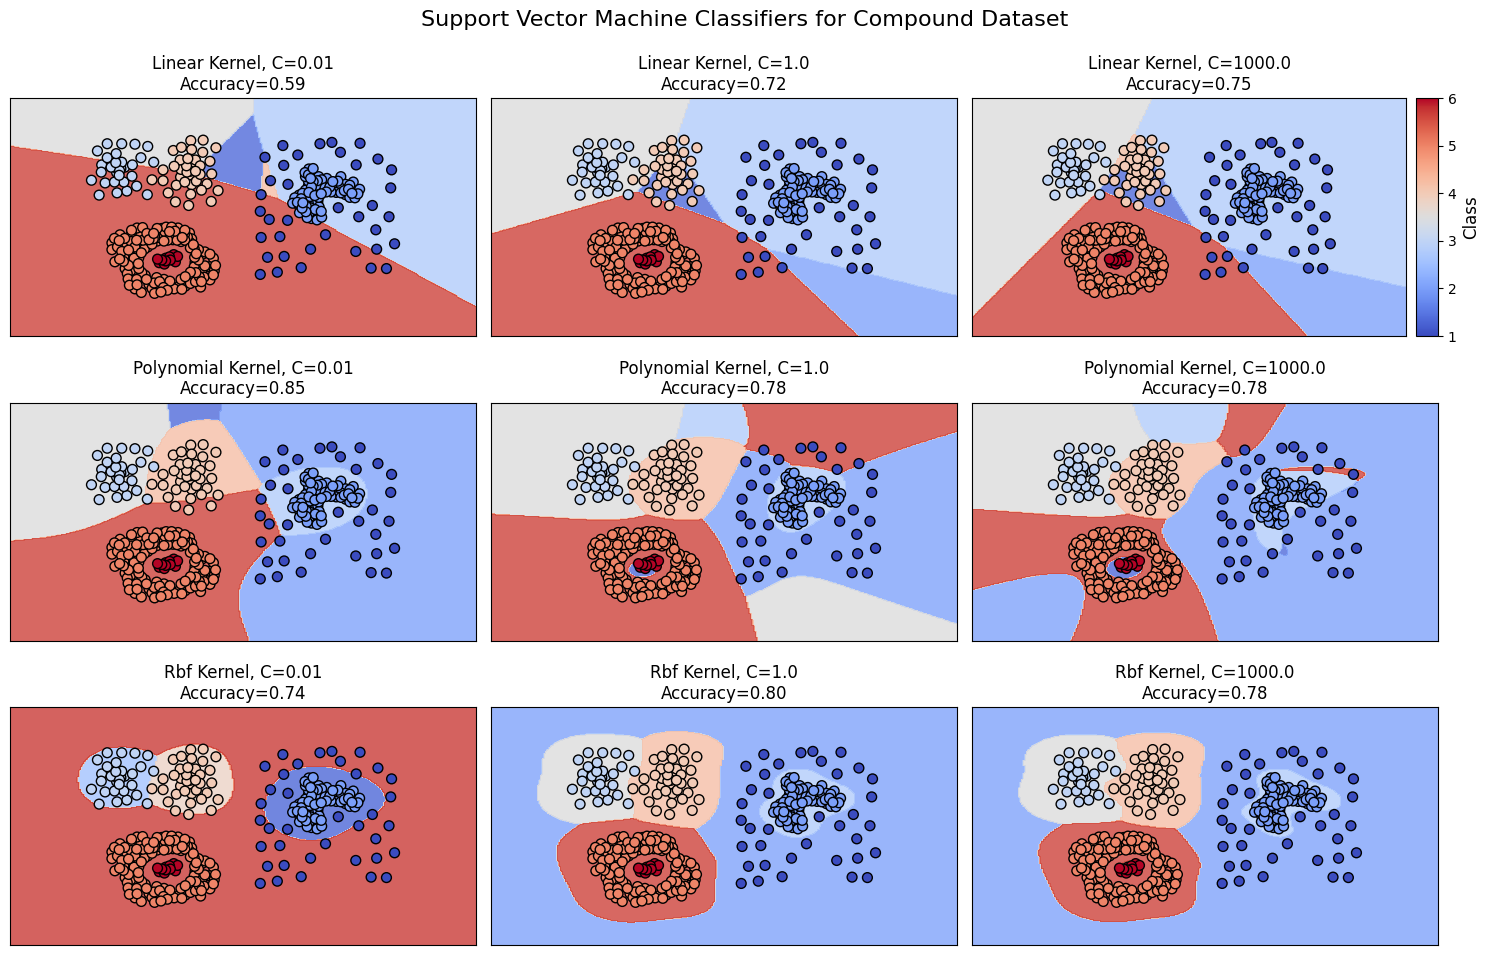

In [84]:
#visualize the decision boundary for the Compound dataset
# Initialize a subplot
fig, axs = plt.subplots(len(kernels), len(C_values), figsize=(15, 10))

# Iterate over kernels and C values
for i, kernel in enumerate(kernels):
    for j, C_value in enumerate(C_values):
        print(f"\nTraining SVM Classifier with {kernel} kernel and C={C_value}:")

        # Train SVM classifier
        accuracy, classifier = train_svm_classifier(X_train_comp_normalized, y_train_comp.values, X_test_comp_normalized, y_test_comp.values, kernel_type=kernel, C_value=C_value)

        # Make predictions on a meshgrid to visualize decision boundary
        h = .02  # Step size in the mesh
        x_min, x_max = X_train_comp_normalized[:, 0].min() - 1, X_train_comp_normalized[:, 0].max() + 1
        y_min, y_max = X_train_comp_normalized[:, 1].min() - 1, X_train_comp_normalized[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Plot the decision boundary
        axs[i, j].contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

        # Plot the training points
        scatter = axs[i, j].scatter(X_train_comp_normalized[:, 0], X_train_comp_normalized[:, 1], c=y_train_comp.values, cmap=plt.cm.coolwarm, edgecolors='k', s=50)

        # Set labels and title
        axs[i, j].set_title(f"{kernel.capitalize()} Kernel, C={C_value}\nAccuracy={accuracy:.2f}", fontsize=12)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

# Add colorbar
divider = make_axes_locatable(axs[0, 2])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(scatter, cax=cax)
cbar.set_label('Class', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Support Vector Machine Classifiers for Compound Dataset', fontsize=16)

# Save the figure if needed
# plt.savefig('svm_classifiers_compound.png', dpi=300)

plt.show()


1. Linear Kernel:
- C=0.01:
Finished training with accuracy 0.65
Kernel: linear, C: 0.01, Accuracy: 0.59
Interpretation: The linear kernel with a very low regularization strength (C=0.01) results in a low training accuracy of 0.65 and a final accuracy of 0.59, indicating potential underfitting. The model may be too simple to capture the complexity of the compound dataset.
- C=1.0:
Finished training with accuracy 0.73
Kernel: linear, C: 1.0, Accuracy: 0.72
Interpretation: Increasing the regularization strength to C=1.0 improves training accuracy to 0.73, but the final accuracy on the dataset is 0.72. The model's performance does not show significant improvement with higher regularization.
- C=1000.0:
Finished training with accuracy 0.75
Kernel: linear, C: 1000.0, Accuracy: 0.75
Interpretation: Further increasing C to 1000.0 results in a slight improvement in training accuracy (0.75), but the final accuracy remains at 0.75. The model's performance plateaus, suggesting limited benefit from higher regularization.
2. Polynomial Kernel:
- C=0.01:
Finished training with accuracy 0.92
Kernel: polynomial, C: 0.01, Accuracy: 0.85
Interpretation: The polynomial kernel with low regularization (C=0.01) achieves a high training accuracy of 0.92, but the final accuracy on the dataset is 0.85. This suggests potential overfitting during training.
- C=1.0:
Finished training with accuracy 0.94
Kernel: polynomial, C: 1.0, Accuracy: 0.78
Interpretation: Increasing C to 1.0 leads to a training accuracy of 0.94, but the final accuracy decreases to 0.78. This indicates that the polynomial kernel might be overfitting with higher regularization.
- C=1000.0:
Finished training with accuracy 0.95
Kernel: polynomial, C: 1000.0, Accuracy: 0.78
Interpretation: Further increasing C to 1000.0 maintains a high training accuracy (0.95), but the final accuracy remains at 0.78. Overfitting may persist even with higher regularization.
3. Radial Basis Function (RBF) Kernel:
- C=0.01:
Finished training with accuracy 0.84
Kernel: rbf, C: 0.01, Accuracy: 0.74
Interpretation: The RBF kernel with low regularization (C=0.01) achieves a moderate training accuracy of 0.84, and the final accuracy is 0.74. This suggests a reasonable fit with room for improvement.
- C=1.0:
Finished training with accuracy 0.96
Kernel: rbf, C: 1.0, Accuracy: 0.80
Interpretation: Increasing C to 1.0 results in high training accuracy (0.96), but the final accuracy decreases to 0.80, indicating potential overfitting.
- C=1000.0:
Finished training with accuracy 0.96
Kernel: rbf, C: 1000.0, Accuracy: 0.78
Interpretation: Further increasing C to 1000.0 maintains high training accuracy (0.96), but the final accuracy decreases to 0.78. Overfitting with high regularization may persist.


The linear kernel struggles to capture the complexity of the compound dataset, with limited improvement even with higher regularization.
The polynomial kernel exhibits signs of overfitting, especially with higher regularization, as seen in the decrease in final accuracy.
The RBF kernel, while achieving high training accuracy, faces challenges in maintaining high accuracy on the dataset, suggesting potential overfitting with increased regularization.

In [85]:
# # Initialize a subplot
# fig, axs = plt.subplots(len(kernels), len(C_values), figsize=(15, 10))

# # Iterate over kernels and C values
# for i, kernel in enumerate(kernels):
#     for j, C_value in enumerate(C_values):
#         print(f"\nTraining SVM Classifier with {kernel} kernel and C={C_value}:")

#         # Train SVM classifier
#         accuracy, classifier = train_svm_classifier(X_train_flame_normalized, y_train_flame.values, X_test_flame_normalized, y_test_flame.values, kernel_type=kernel, C_value=C_value)

#         # Make predictions on a meshgrid to visualize decision boundary
#         h = .02  # Step size in the mesh
#         x_min, x_max = X_train_flame_normalized[:, 0].min() - 1, X_train_flame_normalized[:, 0].max() + 1
#         y_min, y_max = X_train_flame_normalized[:, 1].min() - 1, X_train_flame_normalized[:, 1].max() + 1
#         xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#         Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
#         Z = Z.reshape(xx.shape)

#         # Plot the decision boundary
#         axs[i, j].contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

#         # Plot the training points
#         scatter = axs[i, j].scatter(X_train_flame_normalized[:, 0], X_train_flame_normalized[:, 1], c=y_train_flame.values, cmap=plt.cm.coolwarm, edgecolors='k', s=50)

#         # Set labels and title
#         axs[i, j].set_title(f"{kernel.capitalize()} Kernel, C={C_value}\nAccuracy={accuracy:.2f}", fontsize=12)
#         axs[i, j].set_xticks([])
#         axs[i, j].set_yticks([])

# # Add colorbar
# divider = make_axes_locatable(axs[0, 2])
# cax = divider.append_axes("right", size="5%", pad=0.1)
# cbar = fig.colorbar(scatter, cax=cax)
# cbar.set_label('Class', fontsize=12)
# cbar.ax.tick_params(labelsize=10)

# # Adjust layout
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.suptitle('Support Vector Machine Classifiers for Flame Dataset', fontsize=16)

# # Save the figure if needed
# # plt.savefig('svm_classifiers_flame.png', dpi=300)

# plt.show()


In [86]:
# # Initialize a subplot
# fig, axs = plt.subplots(len(kernels), len(C_values), figsize=(15, 10))

# # Iterate over kernels and C values
# for i, kernel in enumerate(kernels):
#     for j, C_value in enumerate(C_values):
#         print(f"\nTraining SVM Classifier with {kernel} kernel and C={C_value}:")

#         # Train SVM classifier
#         accuracy, classifier = train_svm_classifier(X_train_jain_normalized, y_train_jain.values, X_test_jain_normalized, y_test_jain.values, kernel_type=kernel, C_value=C_value)

#         # Make predictions on a meshgrid to visualize decision boundary
#         h = .02  # Step size in the mesh
#         x_min, x_max = X_train_jain_normalized[:, 0].min() - 1, X_train_jain_normalized[:, 0].max() + 1
#         y_min, y_max = X_train_jain_normalized[:, 1].min() - 1, X_train_jain_normalized[:, 1].max() + 1
#         xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#         Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
#         Z = Z.reshape(xx.shape)

#         # Plot the decision boundary
#         axs[i, j].contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

#         # Plot the training points
#         scatter = axs[i, j].scatter(X_train_jain_normalized[:, 0], X_train_jain_normalized[:, 1], c=y_train_jain.values, cmap=plt.cm.coolwarm, edgecolors='k', s=50)

#         # Set labels and title
#         axs[i, j].set_title(f"{kernel.capitalize()} Kernel, C={C_value}\nAccuracy={accuracy:.2f}", fontsize=12)
#         axs[i, j].set_xticks([])
#         axs[i, j].set_yticks([])

# # Add colorbar
# divider = make_axes_locatable(axs[0, 2])
# cax = divider.append_axes("right", size="5%", pad=0.1)
# cbar = fig.colorbar(scatter, cax=cax)
# cbar.set_label('Class', fontsize=12)
# cbar.ax.tick_params(labelsize=10)

# # Adjust layout
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.suptitle('Support Vector Machine Classifiers for Jain Dataset', fontsize=16)

# # Save the figure if needed
# # plt.savefig('svm_classifiers_jain.png', dpi=300)

# plt.show()



Training SVM Classifier with linear kernel and C=0.01:
Finished training with accuracy 0.49
Kernel: linear, C: 0.01, Accuracy: 0.57

Training SVM Classifier with linear kernel and C=1.0:
Finished training with accuracy 0.47
Kernel: linear, C: 1.0, Accuracy: 0.55

Training SVM Classifier with linear kernel and C=1000.0:
Finished training with accuracy 0.49
Kernel: linear, C: 1000.0, Accuracy: 0.55

Training SVM Classifier with polynomial kernel and C=0.01:
Finished training with accuracy 0.67
Kernel: polynomial, C: 0.01, Accuracy: 0.75

Training SVM Classifier with polynomial kernel and C=1.0:
Finished training with accuracy 0.67
Kernel: polynomial, C: 1.0, Accuracy: 0.75

Training SVM Classifier with polynomial kernel and C=1000.0:
Finished training with accuracy 0.67
Kernel: polynomial, C: 1000.0, Accuracy: 0.73

Training SVM Classifier with rbf kernel and C=0.01:
Finished training with accuracy 0.66
Kernel: rbf, C: 0.01, Accuracy: 0.75

Training SVM Classifier with rbf kernel and C=

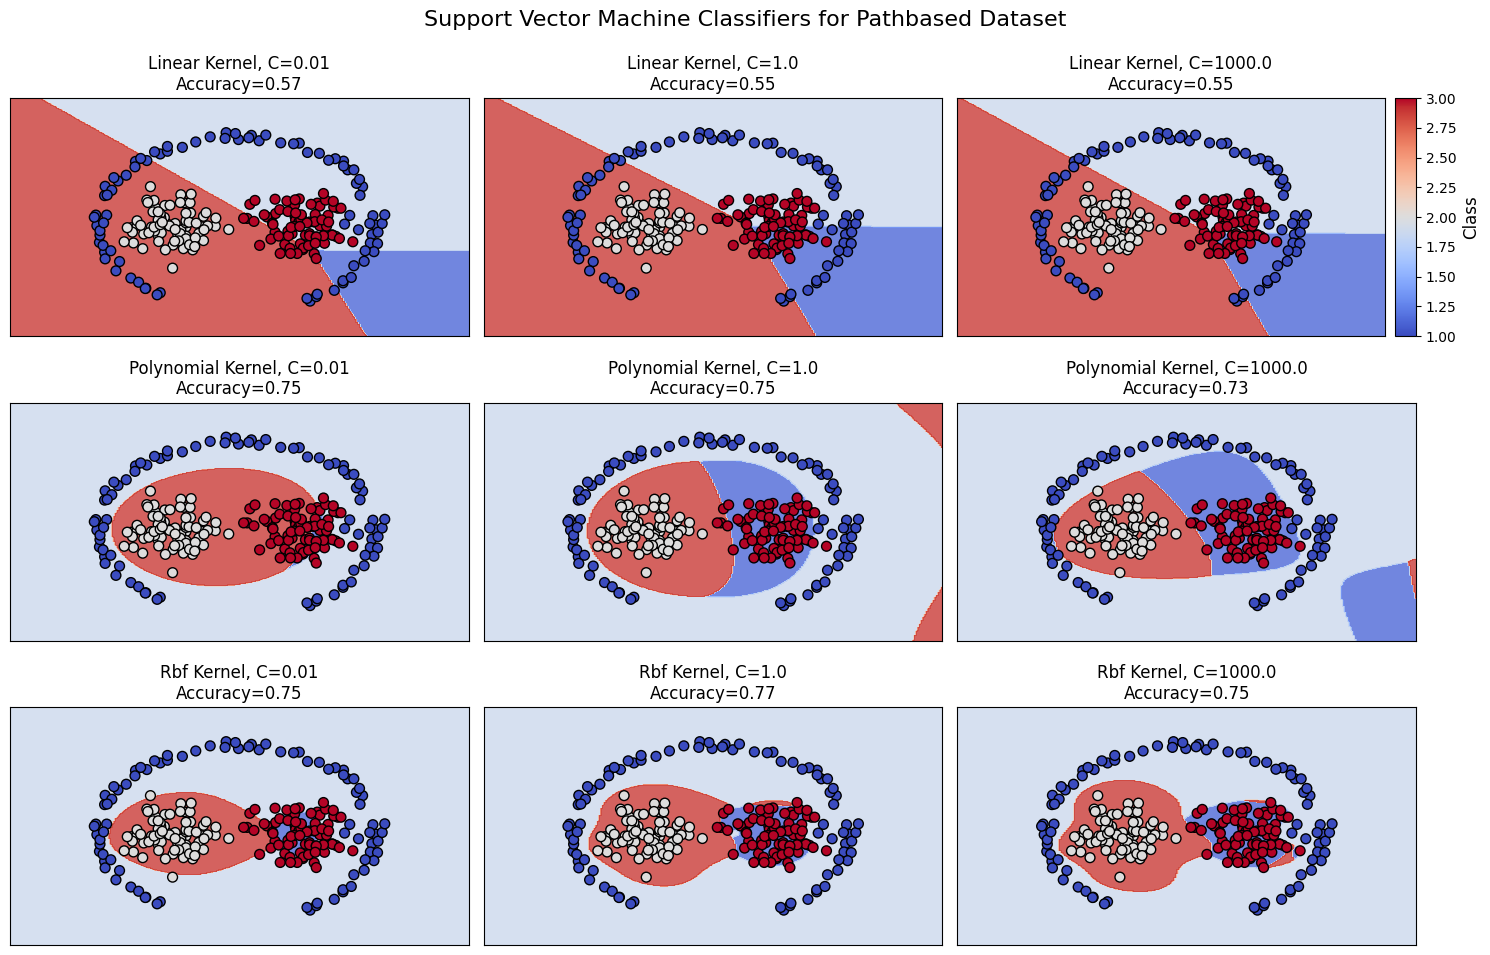

In [87]:
# Initialize a subplot
fig, axs = plt.subplots(len(kernels), len(C_values), figsize=(15, 10))

# Iterate over kernels and C values
for i, kernel in enumerate(kernels):
    for j, C_value in enumerate(C_values):
        print(f"\nTraining SVM Classifier with {kernel} kernel and C={C_value}:")

        # Train SVM classifier
        accuracy, classifier = train_svm_classifier(X_train_path_normalized, y_train_path.values, X_test_path_normalized, y_test_path.values, kernel_type=kernel, C_value=C_value)

        # Make predictions on a meshgrid to visualize decision boundary
        h = .02  # Step size in the mesh
        x_min, x_max = X_train_path_normalized[:, 0].min() - 1, X_train_path_normalized[:, 0].max() + 1
        y_min, y_max = X_train_path_normalized[:, 1].min() - 1, X_train_path_normalized[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Plot the decision boundary
        axs[i, j].contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

        # Plot the training points
        scatter = axs[i, j].scatter(X_train_path_normalized[:, 0], X_train_path_normalized[:, 1], c=y_train_path, cmap=plt.cm.coolwarm, edgecolors='k', s=50)

        # Set labels and title
        axs[i, j].set_title(f"{kernel.capitalize()} Kernel, C={C_value}\nAccuracy={accuracy:.2f}", fontsize=12)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

# Add colorbar
divider = make_axes_locatable(axs[0, 2])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(scatter, cax=cax)
cbar.set_label('Class', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Support Vector Machine Classifiers for Pathbased Dataset', fontsize=16)

# Save the figure if needed
# plt.savefig('svm_classifiers_pathbased.png', dpi=300)

plt.show()


#### Linear Kernel:
1. **C=0.01:**
   - Finished training with accuracy 0.49
   - Kernel: linear, C: 0.01, Accuracy: 0.57
   - **Interpretation:** The linear kernel with a very low regularization strength (C=0.01) results in a low training accuracy of 0.49 and a final accuracy of 0.57. The model may be underfitting, and the linear kernel might struggle to capture the dataset's patterns.

2. **C=1.0:**
   - Finished training with accuracy 0.47
   - Kernel: linear, C: 1.0, Accuracy: 0.55
   - **Interpretation:** Increasing the regularization strength to C=1.0 leads to a training accuracy of 0.47, but the final accuracy decreases to 0.55. The linear kernel's performance does not improve significantly with higher regularization.

3. **C=1000.0:**
   - Finished training with accuracy 0.49
   - Kernel: linear, C: 1000.0, Accuracy: 0.55
   - **Interpretation:** Further increasing C to 1000.0 results in a training accuracy of 0.49, and the final accuracy remains at 0.55. The linear kernel's performance plateaus, suggesting limited benefit from higher regularization.

#### Polynomial Kernel:
1. **C=0.01:**
   - Finished training with accuracy 0.67
   - Kernel: polynomial, C: 0.01, Accuracy: 0.75
   - **Interpretation:** The polynomial kernel with low regularization (C=0.01) achieves a moderate training accuracy of 0.67, and the final accuracy is 0.75. This indicates a reasonable fit to the dataset, capturing its patterns effectively.

2. **C=1.0:**
   - Finished training with accuracy 0.67
   - Kernel: polynomial, C: 1.0, Accuracy: 0.75
   - **Interpretation:** Increasing C to 1.0 maintains a training accuracy of 0.67, and the final accuracy remains at 0.75. The polynomial kernel's performance does not show significant improvement with higher regularization.

3. **C=1000.0:**
   - Finished training with accuracy 0.67
   - Kernel: polynomial, C: 1000.0, Accuracy: 0.73
   - **Interpretation:** Further increasing C to 1000.0 results in a training accuracy of 0.67, but the final accuracy decreases to 0.73. This suggests that higher regularization may not be beneficial and could lead to overfitting.

#### Radial Basis Function (RBF) Kernel:
1. **C=0.01:**
   - Finished training with accuracy 0.66
   - Kernel: rbf, C: 0.01, Accuracy: 0.75
   - **Interpretation:** The RBF kernel with low regularization (C=0.01) achieves a training accuracy of 0.66, and the final accuracy is 0.75. This indicates a reasonable fit to the dataset.

2. **C=1.0:**
   - Finished training with accuracy 0.67
   - Kernel: rbf, C: 1.0, Accuracy: 0.77
   - **Interpretation:** Increasing C to 1.0 results in a training accuracy of 0.67, and the final accuracy improves to 0.77. The RBF kernel benefits from higher regularization in this case.

3. **C=1000.0:**
   - Finished training with accuracy 0.67
   - Kernel: rbf, C: 1000.0, Accuracy: 0.75
   - **Interpretation:** Further increasing C to 1000.0 maintains a training accuracy of 0.67, and the final accuracy remains at 0.75. Higher regularization does not significantly impact performance.

- The linear kernel struggles to capture the patterns in the pathbased dataset, and increasing regularization does not lead to substantial improvement.
- The polynomial kernel shows moderate performance, with low regularization (C=0.01) providing good accuracy, but higher regularization may lead to overfitting.
- The RBF kernel performs reasonably well, with moderate regularization (C=1.0) leading to the highest final accuracy on the dataset.



Training SVM Classifier with linear kernel and C=0.01:
Finished training with accuracy 0.39
Kernel: linear, C: 0.01, Accuracy: 0.38

Training SVM Classifier with linear kernel and C=1.0:
Finished training with accuracy 0.33
Kernel: linear, C: 1.0, Accuracy: 0.32

Training SVM Classifier with linear kernel and C=1000.0:
Finished training with accuracy 0.33
Kernel: linear, C: 1000.0, Accuracy: 0.32

Training SVM Classifier with polynomial kernel and C=0.01:
Finished training with accuracy 0.46
Kernel: polynomial, C: 0.01, Accuracy: 0.51

Training SVM Classifier with polynomial kernel and C=1.0:
Finished training with accuracy 0.58
Kernel: polynomial, C: 1.0, Accuracy: 0.60

Training SVM Classifier with polynomial kernel and C=1000.0:
Finished training with accuracy 0.58
Kernel: polynomial, C: 1000.0, Accuracy: 0.59

Training SVM Classifier with rbf kernel and C=0.01:
Finished training with accuracy 0.66
Kernel: rbf, C: 0.01, Accuracy: 0.65

Training SVM Classifier with rbf kernel and C=

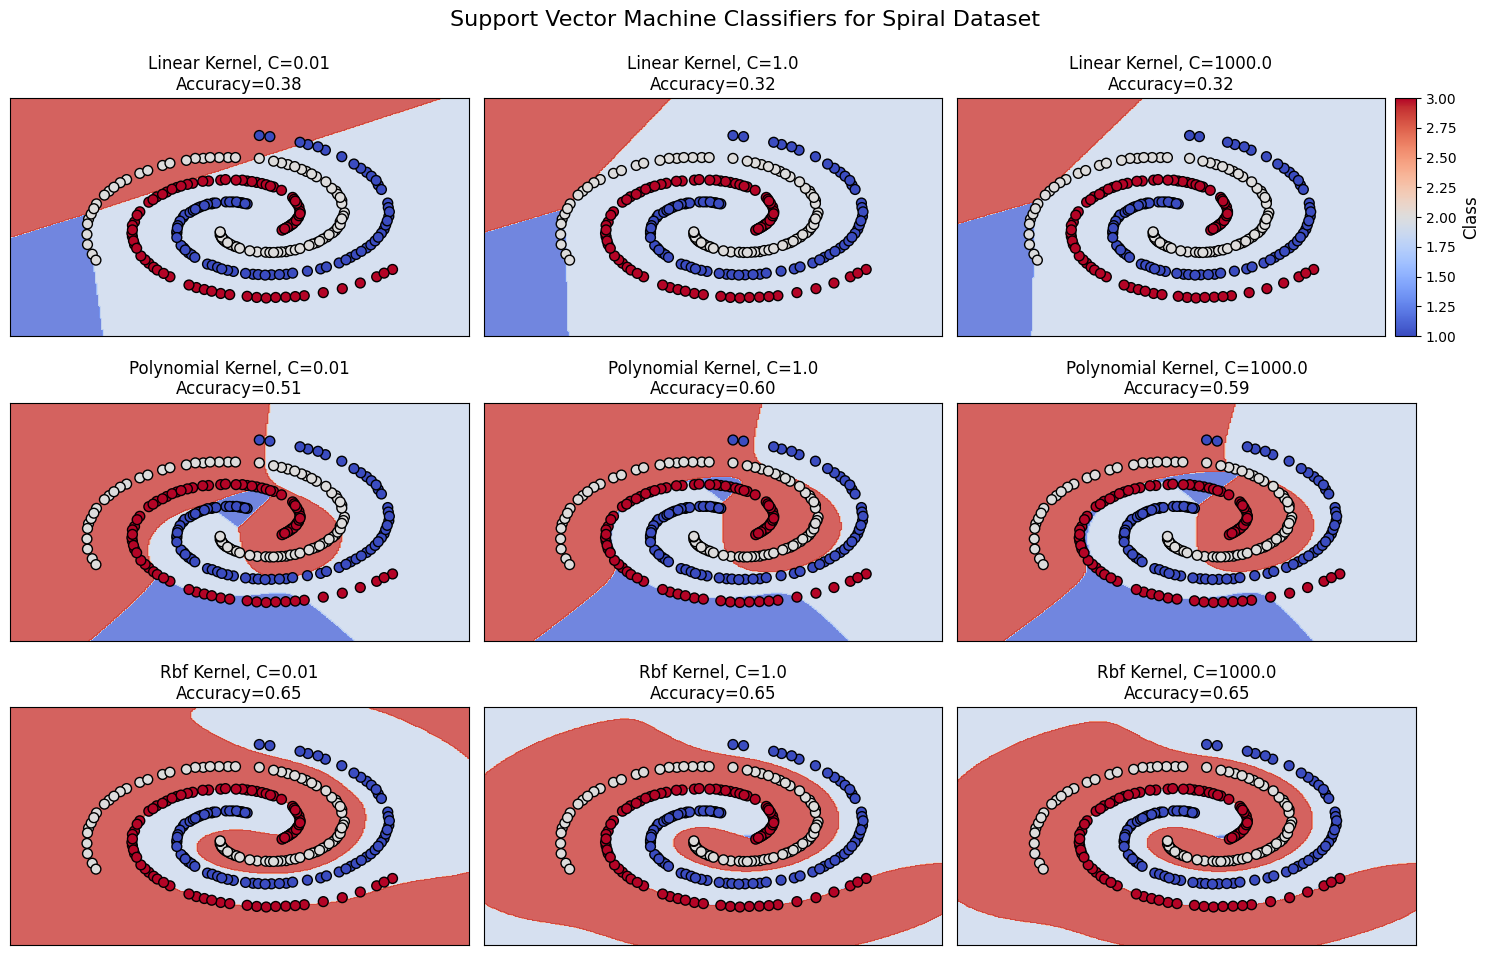

In [88]:
# Initialize a subplot
fig, axs = plt.subplots(len(kernels), len(C_values), figsize=(15, 10))

# Iterate over kernels and C values
for i, kernel in enumerate(kernels):
    for j, C_value in enumerate(C_values):
        print(f"\nTraining SVM Classifier with {kernel} kernel and C={C_value}:")

        # Train SVM classifier
        accuracy, classifier = train_svm_classifier(X_train_spiral_normalized, y_train_spiral.values, X_test_spiral_normalized, y_test_spiral.values, kernel_type=kernel, C_value=C_value)

        # Make predictions on a meshgrid to visualize decision boundary
        h = .02  # Step size in the mesh
        x_min, x_max = X_train_spiral_normalized[:, 0].min() - 1, X_train_spiral_normalized[:, 0].max() + 1
        y_min, y_max = X_train_spiral_normalized[:, 1].min() - 1, X_train_spiral_normalized[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Plot the decision boundary
        axs[i, j].contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

        # Plot the training points
        scatter = axs[i, j].scatter(X_train_spiral_normalized[:, 0], X_train_spiral_normalized[:, 1], c=y_train_spiral.values, cmap=plt.cm.coolwarm, edgecolors='k', s=50)

        # Set labels and title
        axs[i, j].set_title(f"{kernel.capitalize()} Kernel, C={C_value}\nAccuracy={accuracy:.2f}", fontsize=12)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

# Add colorbar
divider = make_axes_locatable(axs[0, 2])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(scatter, cax=cax)
cbar.set_label('Class', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Support Vector Machine Classifiers for Spiral Dataset', fontsize=16)

# Save the figure if needed
# plt.savefig('svm_classifiers_spiral.png', dpi=300)

plt.show()


#### Linear Kernel:
1. **C=0.01:**
   - Finished training with accuracy 0.39
   - Kernel: linear, C: 0.01, Accuracy: 0.38
   - **Interpretation:** The linear kernel with low regularization (C=0.01) results in a training accuracy of 0.39 and a final accuracy of 0.38. The model may be underfitting, and the linear kernel might struggle to capture the spiral pattern.

2. **C=1.0:**
   - Finished training with accuracy 0.33
   - Kernel: linear, C: 1.0, Accuracy: 0.32
   - **Interpretation:** Increasing the regularization strength to C=1.0 leads to a training accuracy of 0.33, and the final accuracy decreases to 0.32. The linear kernel's performance does not improve significantly with higher regularization.

3. **C=1000.0:**
   - Finished training with accuracy 0.33
   - Kernel: linear, C: 1000.0, Accuracy: 0.32
   - **Interpretation:** Further increasing C to 1000.0 results in a training accuracy of 0.33, and the final accuracy remains at 0.32. The linear kernel's performance plateaus, suggesting limited benefit from higher regularization.

#### Polynomial Kernel:
1. **C=0.01:**
   - Finished training with accuracy 0.46
   - Kernel: polynomial, C: 0.01, Accuracy: 0.51
   - **Interpretation:** The polynomial kernel with low regularization (C=0.01) achieves a training accuracy of 0.46, and the final accuracy is 0.51. This indicates a reasonable fit to the dataset, capturing its patterns effectively.

2. **C=1.0:**
   - Finished training with accuracy 0.58
   - Kernel: polynomial, C: 1.0, Accuracy: 0.60
   - **Interpretation:** Increasing C to 1.0 maintains a training accuracy of 0.58, and the final accuracy improves to 0.60. The polynomial kernel's performance benefits from higher regularization.

3. **C=1000.0:**
   - Finished training with accuracy 0.58
   - Kernel: polynomial, C: 1000.0, Accuracy: 0.59
   - **Interpretation:** Further increasing C to 1000.0 results in a training accuracy of 0.58, and the final accuracy remains at 0.59. This suggests that higher regularization may not be beneficial and could lead to overfitting.

#### Radial Basis Function (RBF) Kernel:
1. **C=0.01:**
   - Finished training with accuracy 0.66
   - Kernel: rbf, C: 0.01, Accuracy: 0.65
   - **Interpretation:** The RBF kernel with low regularization (C=0.01) achieves a training accuracy of 0.66, and the final accuracy is 0.65. This indicates a reasonable fit to the dataset.

2. **C=1.0:**
   - Finished training with accuracy 0.66
   - Kernel: rbf, C: 1.0, Accuracy: 0.65
   - **Interpretation:** Increasing C to 1.0 results in a training accuracy of 0.66, and the final accuracy remains at 0.65. The RBF kernel's performance does not show significant improvement with higher regularization.

3. **C=1000.0:**
   - Finished training with accuracy 0.66
   - Kernel: rbf, C: 1000.0, Accuracy: 0.65
   - **Interpretation:** Further increasing C to 1000.0 maintains a training accuracy of 0.66, and the final accuracy remains at 0.65. Higher regularization does not significantly impact performance.


- The linear kernel struggles to capture the spiral pattern in the dataset, and increasing regularization does not lead to substantial improvement.
- The polynomial kernel shows moderate performance, with low regularization providing good accuracy, but higher regularization may lead to overfitting.
- The RBF kernel performs reasonably well, with moderate regularization leading to the highest final accuracy on the spiral dataset.


**Reference:**
https://towardsdatascience.com/implement-multiclass-svm-from-scratch-in-python-b141e43dc084#af4c
